# Data Science and Machine Learning Capstone Project
<div style="text-align: right">
 Dan Thompson         </br> 
 danlthom@us.ibm.com  </br>
 August, 2019         </br>
</div>

## Project 4 - Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

 - The data is unlabled. Unlabled data requires clustering, or some other unsupervised algorithm.
 - I'm going to add an outdoor temperature data set, because HEAT problems mainly occur when the temperature is low
 - The Pluto Data can be ignored. I found no correlation of HEAT problems with any PLUTO features. 
 - While there is 10 years of 311 data, just using the last 5 years is good enough to predict the future
 - Yearly data has been split into 5 folds, rather than using randomizers, so I can compare year to year.
 
 [NYC Policy on Heat/Hot Water](https://www1.nyc.gov/site/hpd/owners/heat-hot-water.page)
 
 
Building owners are legally required to provide heat and hot water to their tenants. Hot water must be provided 365 days per year at a constant minimum temperature of 120 degrees Fahrenheit. Heat must be provided between October 1st and May 31st, i.e. "Heat Season," under the following conditions:  

Day  
Between the hours of 6:00am and 10:00pm, if the outside temperature falls below 55 degrees, the inside temperature is required to be at least 68 degrees Fahrenheit.  

Night  
Between the hours of 10:00pm and 6:00am, the inside temperature is required to be at least 62 degrees Fahrenheit.  
 

In [272]:
# Import libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


In [273]:
# read in the 311 data, already split into folds.
# add Day Of Week
# Drop unneeded columns
df = pd.read_pickle('./files/df_hot.pkl')
df['date_only']=df['created_date'].dt.date
df['DayOfWeek']=df['created_date'].dt.day_name()
df.drop(['complaint_type','address_type','street_name','resolution_description','location_type','status','city'], axis=1, inplace=True)
df.head()

,created_date,incident_zip,incident_address,borough,latitude,longitude,DayOfYear,Year,SEQ,Fold,date_only,DayOfWeek
unique_key,,,,,,,,,,,,
43568281,2019-08-16 07:50:14,11216,751 ST MARKS AVENUE,BROOKLYN,40.675098,-73.947870,228,2019,364,2019,2019-08-16,Friday
43561061,2019-08-16 11:51:14,11224,2843 WEST 25 STREET,BROOKLYN,40.577074,-73.992419,228,2019,364,2019,2019-08-16,Friday
43565793,2019-08-16 22:25:58,10452,80 WEST 170 STREET,BRONX,40.840342,-73.922157,228,2019,364,2019,2019-08-16,Friday
43567272,2019-08-16 06:07:17,10031,723 ST NICHOLAS AVENUE,MANHATTAN,40.824803,-73.944212,228,2019,364,2019,2019-08-16,Friday
43563447,2019-08-16 08:45:38,10461,3108 WILKINSON AVENUE,BRONX,40.851653,-73.828635,228,2019,364,2019,2019-08-16,Friday


In [344]:
df_daily = pd.DataFrame(df['date_only'])
df_daily['daily_complaints'] = 1;
df_daily['date_only'] = df_daily['date_only'].astype(str)
df_daily = df_daily.groupby(by=['date_only']).sum().reset_index().sort_values(by=['date_only'])
df_daily['complaints_7day_avg'] = df_daily['daily_complaints'].rolling(7, win_type='boxcar').mean()
#df_daily.set_index(df_daily['date_only'], inplace=True)
df_daily.drop([0,1,2,3,4,5], inplace=True)
df_daily['date_only'] = pd.to_datetime(df_daily['date_only'])
df_daily.set_index('date_only',inplace=True)


boxes [array([ 97.,  97., 889., 889.,  97.])]
whiskers [array([97., 41.]), array([ 889., 2060.])]
caps [array([41., 41.]), array([2060., 2060.])]
medians [array([354., 354.])]


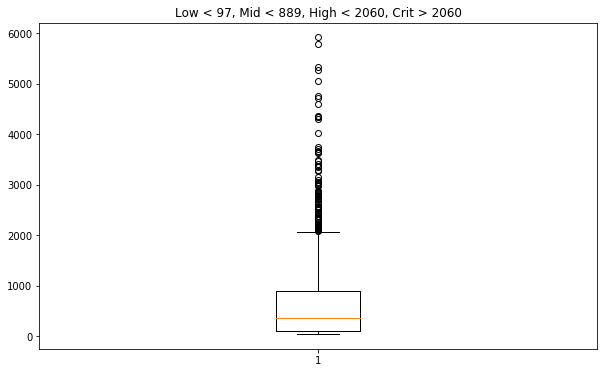

In [345]:
plt.figure(figsize=(10,6))
B = plt.boxplot(df_daily['daily_complaints'])
B
low   = [item.get_ydata() for item in B['whiskers']][0][0]
med   = [item.get_ydata() for item in B['whiskers']][1][0]
high  = [item.get_ydata() for item in B['whiskers']][1][1]
plt.title("Low < %d, Mid < %d, High < %d, Crit > %d"%(low,med,high,high))

print("boxes",[item.get_ydata() for item in B['boxes']])
print("whiskers",[item.get_ydata() for item in B['whiskers']])
print("caps",[item.get_ydata() for item in B['caps']])
print("medians",[item.get_ydata() for item in B['medians']])

Text(0.5, 1.0, 'Complaints over 5 years with Low=97, Med=889, High=2060')

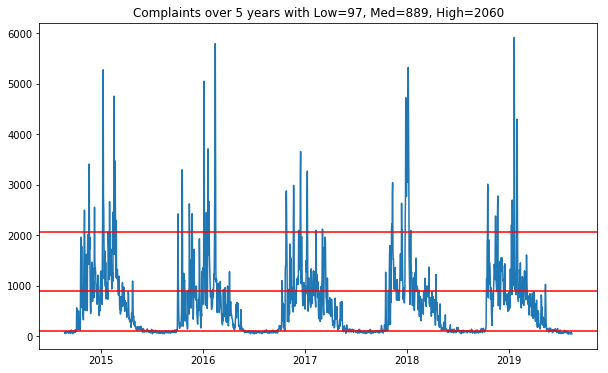

In [346]:
plt.figure(figsize=(10,6))
plt.plot(df_daily['daily_complaints'])

#low = 97
#med = 3*low
#high = 2.25*med
plt.axhline(y=low, color='r', linestyle='-')
plt.axhline(y=med, color='r', linestyle='-')
plt.axhline(y=high, color='r', linestyle='-')

plt.title("Complaints over 5 years with Low=%d, Med=%d, High=%d"%(low,med,high))

In [347]:
df_daily['intensity']=0
ldays = df_daily[df_daily['daily_complaints']<low].count()[0]
mdays = df_daily[(df_daily['daily_complaints']<med)&(df_daily['daily_complaints']>=low)].count()[0]
hdays = df_daily[(df_daily['daily_complaints']<high)&(df_daily['daily_complaints']>=med)].count()[0]
vdays = df_daily[df_daily['daily_complaints']>=high].count()[0]

print("Number of Low Days %d"% ldays)
print("Number of Med Days %d"% mdays)
print("Number of High Days %d"% hdays)
print("Number of Critical Days %d"% vdays)

df_daily.loc[df_daily['daily_complaints'] >high,'intensity'] = 4
df_daily.loc[df_daily['daily_complaints'] <=high,'intensity'] = 3
df_daily.loc[df_daily['daily_complaints'] <=med,'intensity'] = 2
df_daily.loc[df_daily['daily_complaints'] <=low,'intensity'] = 1

df_daily.head()

Number of Low Days 450
Number of Med Days 912
Number of High Days 373
Number of Critical Days 83


,daily_complaints,complaints_7day_avg,intensity
date_only,,,
2014-08-23,71,72.714286,1
2014-08-24,48,72.285714,1
2014-08-25,65,69.857143,1
2014-08-26,65,68.714286,1
2014-08-27,62,65.571429,1


### Join the 311 data with daily temperature lows

In [348]:
df_temperature = pd.read_csv('./files/JFK_temps_seq.csv', index_col=0, parse_dates=[0], usecols=[0,3]).reset_index()
df_temperature['date_only']=df_temperature['DATE'].dt.date
df_temperature.set_index(df_temperature['date_only'], inplace=True)
df_temperature['TMIN_5day_avg'] = df_temperature['TMIN'].rolling(5,win_type='boxcar').mean()
df.head()
df_temperature.head()
df = df.join(df_temperature, on="date_only", how="inner", rsuffix="_R")
df.drop(['date_only_R'],inplace=True,axis=1)




In [349]:
df_temperature
df_daily = df_daily.join(df_temperature, how="inner", rsuffix="_R")
df_daily['DOW'] = df_daily['DATE'].dt.dayofweek
df_daily['DOY'] = df_daily['DATE'].dt.dayofyear
df_daily['WE']  = 0
df_daily.loc[(df_daily['DOW']==5 )|(df_daily['DOW']==6),'WE']=1
df_daily.loc[(df_daily['DOW']==4 ),'WE']=0.5

df_daily['Fold'] = df_daily['DATE'].dt.year
df_daily['InvTMP'] = 100-df_daily['TMIN']

df_daily['HEATING_SEASON']  = 0
df_daily.loc[(df_daily['DOY']<=150 ),'HEATING_SEASON']=1
df_daily.loc[(df_daily['DOY']>=265 ),'HEATING_SEASON']=1

df_daily.drop('DATE', axis=1, inplace=True)
df_daily.drop('complaints_7day_avg', axis=1, inplace=True)
df_daily.head()


,daily_complaints,intensity,TMIN,date_only,TMIN_5day_avg,DOW,DOY,WE,Fold,InvTMP,HEATING_SEASON
date_only,,,,,,,,,,,
2014-08-23,71,1,66,2014-08-23,66.0,5,235,1.0,2014,34,0
2014-08-24,48,1,62,2014-08-24,65.6,6,236,1.0,2014,38,0
2014-08-25,65,1,63,2014-08-25,65.0,0,237,0.0,2014,37,0
2014-08-26,65,1,67,2014-08-26,65.0,1,238,0.0,2014,33,0
2014-08-27,62,1,67,2014-08-27,65.0,2,239,0.0,2014,33,0


In [350]:
df_daily.loc['2019-08-16']

daily_complaints            46
intensity                    1
TMIN                        67
date_only           2019-08-16
TMIN_5day_avg               69
DOW                          4
DOY                        228
WE                         0.5
Fold                      2019
InvTMP                      33
HEATING_SEASON               0
Name: 2019-08-16 00:00:00, dtype: object

In [351]:
df_daily.head()

,daily_complaints,intensity,TMIN,date_only,TMIN_5day_avg,DOW,DOY,WE,Fold,InvTMP,HEATING_SEASON
date_only,,,,,,,,,,,
2014-08-23,71,1,66,2014-08-23,66.0,5,235,1.0,2014,34,0
2014-08-24,48,1,62,2014-08-24,65.6,6,236,1.0,2014,38,0
2014-08-25,65,1,63,2014-08-25,65.0,0,237,0.0,2014,37,0
2014-08-26,65,1,67,2014-08-26,65.0,1,238,0.0,2014,33,0
2014-08-27,62,1,67,2014-08-27,65.0,2,239,0.0,2014,33,0


Text(0.5, 1.0, 'Complaints over 5 years with Low=97, Med=889, High=2060')

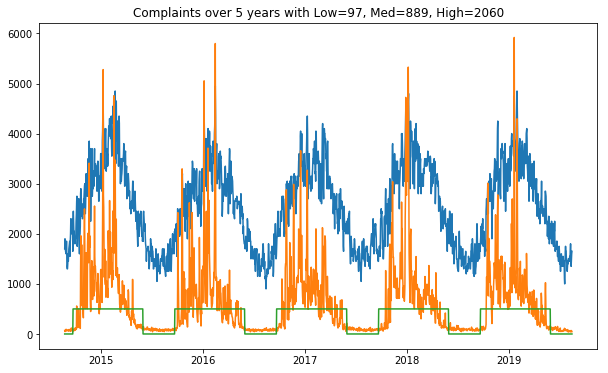

In [352]:
plt.figure(figsize=(10,6))
plt.plot(df_daily['InvTMP']*50)
plt.plot(df_daily['daily_complaints'])
plt.plot(df_daily['HEATING_SEASON']*500)

#low = 97
#med = 3*low
#high = 2.25*med
#plt.axhline(y=low, color='r', linestyle='-')
#plt.axhline(y=med, color='r', linestyle='-')
#plt.axhline(y=high, color='r', linestyle='-')

i = 0
x=2015
#plt.axvline(x='2015-03-01', color='r', linestyle='-')
#plt.axvline(x='2016-03-01', color='r', linestyle='-')
#plt.axvline(x='2017-03-01', color='r', linestyle='-')
#plt.axvline(x='2018-03-01', color='r', linestyle='-')
#plt.axvline(x='2019-03-01', color='r', linestyle='-')#
#
#plt.axvline(x='2015-09-21', color='g', linestyle='-')
#plt.axvline(x='2016-09-21', color='g', linestyle='-')
#plt.axvline(x='2017-09-21', color='g', linestyle='-')
#plt.axvline(x='2018-09-21', color='g', linestyle='-')
#plt.axvline(x='2014-09-21', color='g', linestyle='-')


plt.title("Complaints over 5 years with Low=%d, Med=%d, High=%d"%(low,med,high))

Text(0.5, 1.0, "Fold 2015 - RSME='473.1' R2='0.80'")

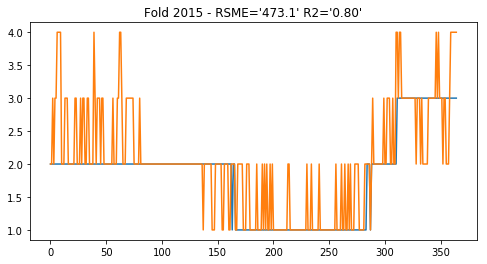

In [343]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm

limit = 180
t = np.arange(0,limit,1)
year = 2018
year2 = 2017

df['count']=1
y_train = df_daily[(df_daily['Fold']==year2)]['intensity']
X_Train = df_daily[(df_daily['Fold']==year2)][['TMIN','DOW','DOY','HEATING_SEASON']]
y_test  = df_daily[(df_daily['Fold']==year2)]['intensity']
X_Test  = df_daily[(df_daily['Fold']==year2)][['TMIN','DOW','DOY','HEATING_SEASON']]

scaler = StandardScaler(copy=True, with_mean=False, with_std=False)

X_Train = scaler.fit_transform(X_Train)
X_Test = scaler.fit_transform(X_Test)

#clf = RandomForestClassifier(n_jobs=9, random_state=0)
clf = svm.SVC(gamma='scale')

clf.fit(X_Train,y_train)
yhat = clf.predict(X_Test)

results = pd.DataFrame( X_Test , yhat).reset_index()
results.columns=['Intensity','TMIN','DOW','DOY','HEATING_SEASON']

plt.figure(figsize=(8,4))
#fig, ax1 = plt.subplots()

#plt.subplot(121)
plt.plot(yhat)
#plt.subplot(122)
plt.plot(np.array(y_test))
#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(title)

#df_r = pd.DataFrame(y_test[:limit])
#plt.show()

#df_r.plot()



## Join daily temps with daily call volume

In [289]:
df_daily[['daily_complaints','TMIN','WE']].corr()


,daily_complaints,TMIN,WE
daily_complaints,1.000000,-0.771250,-0.027622
TMIN,-0.771250,1.000000,-0.016422
WE,-0.027622,-0.016422,1.000000


In [271]:
df_daily.head()

,daily_complaints,intensity,TMIN,date_only,TMIN_5day_avg,DOW,DOY,WE,Fold,InvTMP
date_only,,,,,,,,,,
2014-08-23,71,1,66,2014-08-23,66.0,5,235,1.0,2014,34
2014-08-24,48,1,62,2014-08-24,65.6,6,236,1.0,2014,38
2014-08-25,65,1,63,2014-08-25,65.0,0,237,0.0,2014,37
2014-08-26,65,1,67,2014-08-26,65.0,1,238,0.0,2014,33
2014-08-27,62,1,67,2014-08-27,65.0,2,239,0.0,2014,33


In [8]:
df.columns

Index(['created_date', 'incident_zip', 'incident_address', 'borough',
       'latitude', 'longitude', 'DayOfYear', 'Year', 'SEQ', 'Fold',
       'date_only', 'DayOfWeek', 'DATE', 'TMIN', 'TMIN_5day_avg'],
      dtype='object')

## Now we'll count

In [9]:
#
#
#
df_1 = df[(df['Fold']==2019)][['incident_zip', 'incident_address','date_only','latitude','longitude','TMIN','TMIN_5day_avg','DayOfYear','Fold','DayOfWeek']]
df_1['count']=1
df_1.head()
df_2 = df_1.groupby(by=['incident_zip', 'incident_address','date_only','latitude','longitude','TMIN','TMIN_5day_avg','DayOfYear','Fold','DayOfWeek']).sum()
df_2.sort_values(by="count", ascending=False, inplace=True)
df_2.reset_index(inplace=True)

df_2.head()

,incident_zip,incident_address,date_only,latitude,longitude,TMIN,TMIN_5day_avg,DayOfYear,Fold,DayOfWeek,count
0,10468,2485 MORRIS AVENUE,2018-12-03,40.862935,-73.899520,46,39.4,337,2019,Monday,141
1,10467,3864 WHITE PLAINS ROAD,2019-02-05,40.885246,-73.861871,32,22.8,36,2019,Tuesday,124
2,11233,1711 FULTON STREET,2018-10-23,40.679340,-73.930435,47,43.8,296,2019,Tuesday,122
3,11373,89-21 ELMHURST AVENUE,2018-10-21,40.747420,-73.876853,40,44.2,294,2019,Sunday,87
4,10467,3864 WHITE PLAINS ROAD,2019-01-30,40.885246,-73.861871,7,20.8,30,2019,Wednesday,84


starts at 5:00AM, dip mid-afternoon, bump at 10:00PM


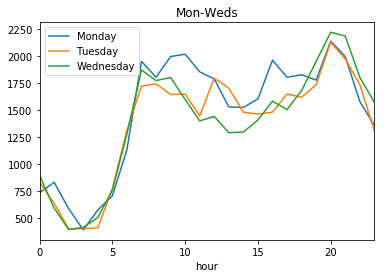

In [10]:
df_1 = df[(df['Fold']==2019)][['created_date','DayOfWeek']]

df_1['hour'] = df_1['created_date'].dt.hour
df_1.drop(['created_date'],axis=1,inplace=True)
df_1 = pd.get_dummies(df_1['DayOfWeek']).join(df_1)

df_1.groupby(by="hour").sum()[['Monday','Tuesday','Wednesday']].plot()
plt.title("Mon-Weds")
print ("starts at 5:00AM, dip mid-afternoon, bump at 10:00PM")




starts at 7:00AM, dip at mid-afternoon, no bump at 10:00PM


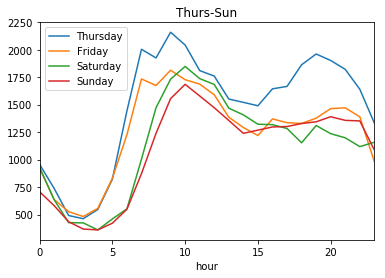

In [11]:
df_1.groupby(by="hour").sum()[['Thursday','Friday','Saturday','Sunday']].plot()
plt.title("Thurs-Sun")
print ("starts at 7:00AM, dip at mid-afternoon, no bump at 10:00PM")

## Now plot the average number of calls by temperature

/Users/dtt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


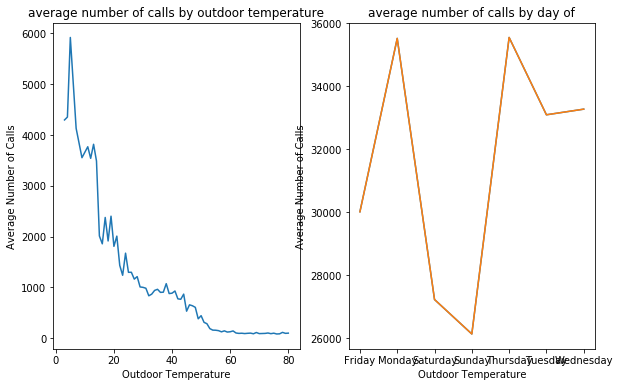

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

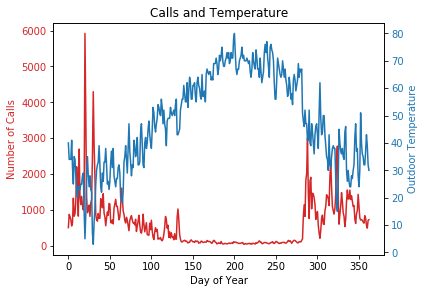

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

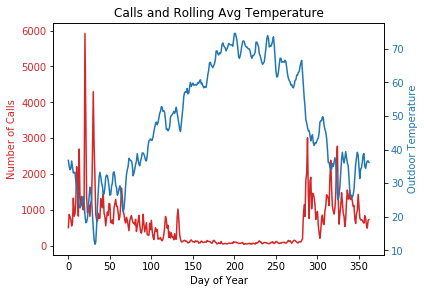

In [12]:
df['count']=1
plt.figure(figsize=(15,6))
plt.subplot(131)
df_temp_plan = df[(df['Fold']>=2017)][['DayOfYear','TMIN','count']].groupby(['DayOfYear','TMIN']).sum().groupby('TMIN').mean()
plt.plot(df_temp_plan)
plt.title("average number of calls by outdoor temperature")
plt.xlabel('Outdoor Temperature')
plt.ylabel('Average Number of Calls')

plt.subplot(132)
df_temp_plan = df[(df['Fold']>=2019)][['DayOfWeek','count']].groupby(['DayOfWeek']).sum()
plt.plot(df_temp_plan)
plt.title("average number of calls by day of")
plt.xlabel('Outdoor Temperature')
plt.ylabel('Average Number of Calls')

plt.subplot(132)
df_temp_plan = df[(df['Fold']>=2019)][['DayOfWeek','count']].groupby(['DayOfWeek']).sum()
plt.plot(df_temp_plan)
plt.title("average number of calls by day of")
plt.xlabel('Outdoor Temperature')
plt.ylabel('Average Number of Calls')

def plot_by_year(year, how, title, limit=363):
    #plt.subplot(122)
    plt.figure(figsize=(15,6))
    df['count']=1
    data1 = (df[(df['Fold']==year)][['DayOfYear','count']].groupby(by='DayOfYear').count())
    data2 = (df[(df['Fold']==year)][['DayOfYear',how]].groupby(by='DayOfYear').mean())
    #data3 = (df[(df['Fold']==year)][['DayOfYear',how]].groupby(by='DayOfYear').mean())
    #plt.title("311 calls by day of year")
    t = np.arange(0,limit,1)

    plt.figure(figsize=(15,6))
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Day of Year')
    ax1.set_ylabel('Number of Calls', color=color)
    ax1.plot(t, data1[:limit], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Outdoor Temperature', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, data2[:limit], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.show()

plot_by_year(2019,'TMIN', 'Calls and Temperature')
plot_by_year(2019,'TMIN_5day_avg','Calls and Rolling Avg Temperature')

#plot_by_year(2017)
#plot_by_year(2016)
#plot_by_year(2015)



### What this tells us is that Heat Related 311 calls mainly happen in the winter, or colder months. 
 - They are low during the warmer months, when the temperature goes above 40
 - They spike when the temperature dips
 - They begin to pick up in the fall
 - There are fewer calls in the late winter than in the fall, even though the temperatures are colder
 - But it really looks like the number of calls is related to steep downward changes in temperature.
 
 
### I think what we should do is this
 - Just use time series data showing total calls per day, well, we kind of have that
 - What about a running average of calls for the last week? Are they a good predictor of calls going forward?
 - There are two related factors, which is day of year, and temperature
 - 
 - We already have a pretty good break down of calls per hour by day
 - 


## First - Do a polynomial regression against temperature and mean number of calls
 - This will give us our first model to predict number of calls for heating issues

Best R Score for Best K 6 is 0.824336872172457
LR Coefficients: [ 0.00000000e+00 -6.68764867e+01 -2.38810765e+01  1.52130156e+00
 -3.78558895e-02  4.24555530e-04 -1.78275151e-06]
LR Intercept: 5111.382329641067
----


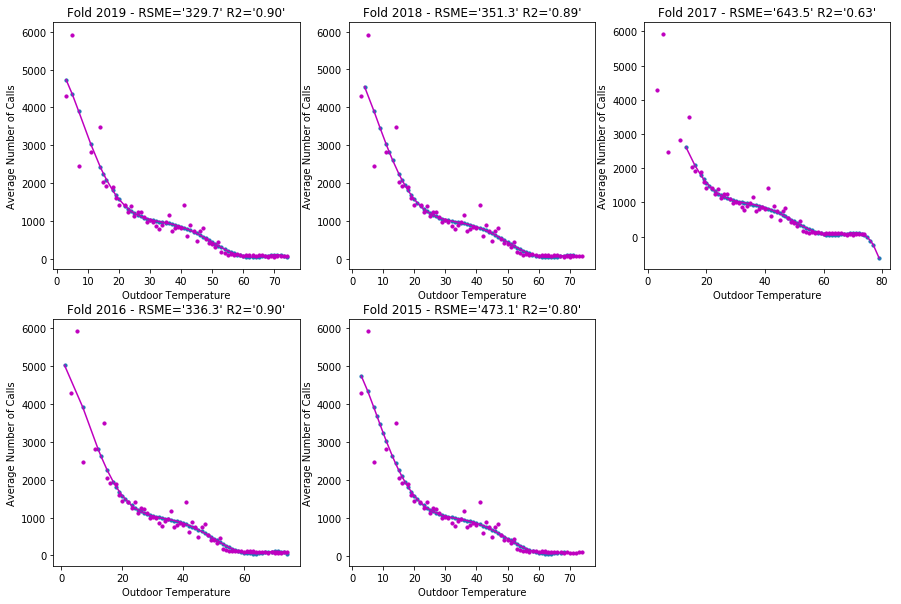

In [13]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


X = [[],[],[],[],[],[]]

for i in range(2015,2020):
    X[i-2015] = np.array(df[df['Fold']==i][['SEQ','TMIN','count']].groupby(['SEQ','TMIN']).count().groupby('TMIN').mean()[:63].reset_index()[['TMIN']])
    y = np.array(df[df['Fold']==i][['SEQ','TMIN','count']].groupby(['SEQ','TMIN']).count().groupby('TMIN').mean()[:63].reset_index()['count'])

# First find the best K value to use for polynomial expression. What degree of polynomial works best without overfitting?
this_year = 4
best_r = 0
best_k = 1
for k in range(1,11):
    #y=X[this_year]['count']
    polynomial_features= PolynomialFeatures(degree=k)
    x_poly = polynomial_features.fit_transform(X[this_year])

    model = LinearRegression()
    model.fit(x_poly, y)
      
    tot_k = 0

    for n in range(0,5):
        i = 4-n
        y_poly_pred = model.predict(polynomial_features.fit_transform(X[i]))

        rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
        r2 = r2_score(y,y_poly_pred)
        tot_k += r2

    if (tot_k > best_r):
        best_r = tot_k
        best_k = k
        
# Now that we've found the best K, let's plot all the temperatures as a sanity check
print("Best R Score for Best K",best_k,"is",best_r/5)
polynomial_features= PolynomialFeatures(degree=best_k)
x_poly = polynomial_features.fit_transform(X[this_year])

model = LinearRegression()
model.fit(x_poly, y)

print("LR Coefficients:",model.coef_)
print("LR Intercept:",model.intercept_)
print("----")

matrix=231
plt.figure(figsize=(15,10))

for n in range(0,5):
    plt.subplot(matrix+n)

    i = 4-n
    y_poly_pred = model.predict(polynomial_features.fit_transform(X[i]))

    rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
    r2 = r2_score(y,y_poly_pred)
    
    
    title = "Fold %d - RSME='%3.1f' R2='%2.2f'"%((2019-n),rmse,r2)
    tot_k += r2
    plt.scatter(X[i], y_poly_pred[::], s=10 )
    plt.scatter(X[this_year], y[::], s=10 ,color='m')
    plt.plot(X[i], y_poly_pred, color='m')
    plt.title(title)
    plt.xlabel('Outdoor Temperature')
    plt.ylabel('Average Number of Calls')

  
plt.show()    

### A polynomial of degree 6 seems to give the most consisten R value for Outdoor Temperature vs average number of daily calls

## First Results
 - 311 Heat related calls are related to the outdoor temperature as shown over a five year period. The results are consistent with an R score as high as .90

<Figure size 1080x432 with 0 Axes>

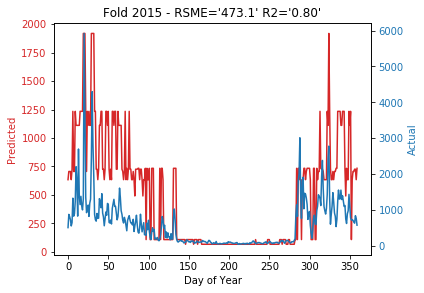

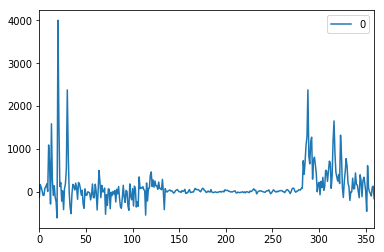

In [23]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm

year=2019
how = 'TMIN'
limit=360
t = np.arange(0,limit,1)

df['count']=1
y_train = (df[(df['Fold']==year)][['DayOfYear','count']].groupby(by='DayOfYear').count()).values.ravel()
X_Train = (df[(df['Fold']==year)][['DayOfYear',how]].groupby(by='DayOfYear').mean())
y_test =  (df[(df['Fold']==year)][['DayOfYear','count']].groupby(by='DayOfYear').count()).values.ravel()
X_Test =  (df[(df['Fold']==year)][['DayOfYear',how]].groupby(by='DayOfYear').mean())

#X1 = np.array(df1[["Latitude", "Longitude", "TMIN"]])
#y1 = np.array(df1[['count']].values.ravel())

scaler = StandardScaler(copy=True, with_mean=False, with_std=False)

X_Train = scaler.fit_transform(X_Train)
X_Test = scaler.fit_transform(X_Test)
#y = scaler.fit_transform(y)

#X_Train, X_Test, y_train, y_test = train_test_split(X1,y,test_size=0.20)

#clf = RandomForestClassifier(n_jobs=9, random_state=0)
#clf.fit(X_Train,y_train)
#yhat = clf.predict(X_Test)


clf = svm.SVC(gamma='scale')

clf.fit(X_Train,y_train)
yhat = clf.predict(X_Test)

results = pd.DataFrame( X_Test , yhat).reset_index()
results.columns=['Complaints','Temp']
#results.plot(kind="scatter", x="Temp", y="Complaints")

plt.figure(figsize=(15,6))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Day of Year')
ax1.set_ylabel('Predicted', color=color)
ax1.plot(t, yhat[:limit], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
t = np.arange(0,limit,1)
color = 'tab:blue'
ax2.set_ylabel('Actual', color=color)  # we already handled the x-label with ax1
ax2.plot(t, y_test[:limit], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(title)

df_r = pd.DataFrame(y_test[:limit] - yhat[:limit])
plt.show()

df_r.plot()



### So let's take that model and run it against weather data and see if it compares to actual!

## Next let's set up some classifiers and see if we can predict more about when Heat related 311 calls will come in
 - Set up our folds again, 

## Let's run some classifications

In [15]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr

def do_forest(X_Train, y_train, X_Test, y_test):
    clf = RandomForestClassifier(n_jobs=2, random_state=0)
    clf.fit(X_Train,y_train)
    yhat = clf.predict(X_Test)

    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    labels = ["Latitude", "Longitude", "count", "TMIN"]
    # Print the feature ranking
    #print("Feature ranking:",X.shape[1],importances.shape)

    i = 0
    for f in range(X_Train.shape[1]):
        print("%d. feature %d %s (%f)" % (f + 1,  indices[f], labels[indices[f]], importances[indices[f]]))
        i = i + 1
        if (i == 8):
            break

In [16]:
from sklearn import svm

def do_SVM(X_Train, y_train, X_Test, y_test):
    clf = svm.SVC(gamma='scale')
    print(clf)
    print(y_train)
  
    clf.fit(X_Train,y_train)
    yhat = clf.predict(X_Test)

    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    labels = ["Latitude", "Longitude", "count", "TMIN"]
    # Print the feature ranking
    #print("Feature ranking:",X.shape[1],importances.shape)

    i = 0
    for f in range(X_Train.shape[1]):
        print("%d. feature %d %s (%f)" % (f + 1,  indices[f], labels[indices[f]], importances[indices[f]]))
        i = i + 1
        if (i == 8):
            break
            
#do_classifier("SVM")

In [17]:

from sklearn.naive_bayes import GaussianNB

def do_NB(X_Train, y_train, X_Test, y_test):
    clf = GaussianNB()
    clf.fit(X_Train,y_train)
    yhat = clf.predict(X_Test)

    x = y_test.shape[0];
    y = (y_test != yhat).sum()
    r = 1-(y/x)
    
    print("Naive Bayes Accurately Predicts 311 Calls %0.2f percent of the time" % r)
            
#do_classifier("NB")

In [18]:
# Create Training / Test Data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def do_classifier(ctype):
    for i in range(1,6):
        df1 = df[df['Fold']==i+2014][['SEQ','incident_zip','Fold','TMIN','latitude','longitude']]
        df1['problem count']=1
#        df1.groupby(by=['SEQ','incident_zip','Fold','TMIN','latitude','longitude']).count().reset_index()
        print(df1.head())

    
do_classifier("forest")


            SEQ incident_zip  Fold  TMIN   latitude  longitude  problem count
unique_key                                                                   
30033996    191        11238  2015     7  40.673037 -73.962854              1
30017624    191        10024  2015     7  40.784132 -73.981335              1
30017640    191        10128  2015     7  40.780006 -73.950207              1
30017712    191        10460  2015     7  40.842849 -73.869564              1
30018765    191        10459  2015     7  40.831536 -73.896778              1
            SEQ incident_zip  Fold  TMIN   latitude  longitude  problem count
unique_key                                                                   
31954501     85        11238  2016    53  40.673037 -73.962854              1
31951487     85        10032  2016    53  40.835600 -73.948738              1
31951489     85        10453  2016    53  40.850137 -73.917584              1
31951490     85        11433  2016    53  40.699609 -73.792385  

In [15]:
do_classifier("forest")

print("This shows the random forest classifier picks good values for predicting where 311 HEAT related calls will come in")

This shows the random forest classifier picks good values for predicting where 311 HEAT related calls will come in


In [16]:
do_classifier("NB")

print("This shows the Naive Bayse classifier picks good values for predicting where 311 HEAT related calls will come in")

This shows the Naive Bayse classifier picks good values for predicting where 311 HEAT related calls will come in


## 2nd Results
 - This shows that the ResArea of a building is the best indicator that it will generate HEAT related 311 calls
 - But that outdoor temperature is also a major factor in generating these calls
 - Repeated for five years worth of data
 

# Conclusions

Overall results showed a positive correlation between outdoor temperature and 311 calls related to HEAT or HEAT/HOT WATER. The colder the temperatures the more daily calls are be generated.  

In addition, it was shown that the Residential Area of a building is the most important factor in determining whether it will generate these types of 311 calls.  While Age of the building and the number of floors in the building had little relevance.

Data used included information from the 311 database, the PLUTO database, and NYC Weather data from NOAA.
 - 311 data included at least 10 years of information. I decided to use only the last 5 years, as this seemed most relevent to predicting future calls.
 - 311 data was split into five individual folds of 364 days each. These were used as separate test and training in order to validate assumptions for prior years.
 - Only the minimum temperature for the day was considered as a measure as it seemed like the coldest parts of the coldest days would generate the most calls. Further study of daytime temperatures in relation to the distribution of calls throughout the day would require futher study.

Methods used included visualization to verify that the data were indeed useful, and that the assumptions were correct. Some methods led to dead ends, such as several attempts at classificating zipcodes. These sideline studies were kept in this notebook for possible further development later on.

Polynomial Regression was used to model temperature data. An 8th degree polynomial fit the data with an average R score of 80 when tested across five individual years. Random Forest Classification was used to model building data, and showed that certain features of the building were important in predicting whether it would generate these types of 311 calls. Naive Bayes was used for with the same parameters as RFC, and showed between 60% and 75% accuracy that a given building would generate 311 calls on a given day, which are very good results. Or at least better than guessing.

In addtion to these techniques I used correlation to show that some variables were good proxies for others. For example, ResArea and BuiltArea tracked at 0.99, and therefore one could be removed from the feature set. This is an example of feature reduction.

For feature creation, I added the daily temperature data, but I also built aggregates of call counts vs temperature, and for the daily tallies.  I also created five folds in the data in order to cross validate my assumptions.

Other insights - It is important to note that on median each zipcode only produces 3 complaints annually. Therefore it is crucial to stay on top of the highest call generating zipcodes, which I have documented in this study. 


Daniel Thompson  
danlthom@us.ibm.com  
August 2019  


